# Explorations des descripteurs appliqués au violon (code 2.0 de Coline)

Ce code reprend en partie les codes de Coline et Lalie respectivement sur le modèle physique du violon et sur l'utilisation de descripteurs.

Sont utilisés dans ce code les articles de Olliver, Dalmont Kergomard ; Vergez ; Salvador Castrillo

Sont explorés des métriques sur la production d'un son, de la justesse, de type de régime et de la longueur du régime transitoire.

Il y a beaucoup de choses qui nécessitent discussion, notamment sur le choix d'étude de q (qui n'a après étude jamais de régime de Helmholtz) et de choses qui en découlent comme le choix des descripteurs liés au type de régime et sur la durée des transitoires (pas de Helmholtz = que du transitoire...)

Anyway, hf


In [61]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time
from numba import njit
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as mticker
import scipy.io

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import write
import os
from time import time

class SimulateurViolon:
    def __init__(self, T_sec=0.1, L=0.325, Fb=0.2, vb=0.45, beta=5/16):
        # Paramètres physique
        self.T_sec = T_sec                                                       # Durée du signal (s)
        self.L = L                                                               # longueur de la corde (m)
        self.Fb = Fb                                                             # force de l'archet (N) -- valeur réaliste = < 5 N
        self.vb = vb                                                             # vitesse de l'archet (m/s) -- valeur réaliste < 0.5 m/s
        self.beta = beta                                                         # ratio du point de contact entre la corde et l'archet
        
        self.d = 0.45e-3                                                         # diamètre de la corde LA (m) 
        self.R = self.d/2                                                        # rayon de la corde (m)
        self.T_tension = 6*9.81                                                  # Tension pour une corde de LA (N)
        self.Area = np.pi * self.R**2                                            # section de la corde (m^2)
        self.mu = 7.19595e-4                                                     # masse linéique (kg/m)
        self.rho = self.mu / self.Area                                           # masse volumique (kg/m3)
        self.c = np.sqrt(self.T_tension/self.mu)                                 # vitesse du son (m/s)
        self.Zc = self.rho * self.c * self.Area                                  # impédance (kg/s)
        self.Yc = 1/self.Zc                                                      # admittance (s/kg)
        self.Yc_half = self.Yc / 2                                               # demi admittance
        self.v0 = 0.05                                                           # paramètre de contrôle tenant compte des coeffs de viscosité dynamique et statique (m/s)
        
        # Paramètres de simulation
        self.fs = 44100                                                          # sampling rate
        self.delta_t = 1/self.fs                                                 # pas de temps (s)
        self.L_L = self.L * self.beta                                            # longueur de la partie droite de la corde (m)
        self.L_R = self.L * (1 - self.beta)                                      # longueur de la partie droite de la corde (m)
        self.T_L = 2 * self.L_L / self.c                                         # temps de parcours d'un aller-retour sur la moitié gauche de la corde (s)
        self.T_R = 2 * self.L_R / self.c                                         # temps de parcours d'un aller-retour sur la moitié droite de la corde (s)
        
        # Retards en samples (D_L et D_R)
        self.D_L = int(np.rint(self.T_L * self.fs))
        self.D_R = int(np.rint(self.T_R * self.fs))

        # Données modales / adaptation violon
        self.Nmod = 88
        Wmod_base = np.array([457.8, 606.1, 937.6, 1227.6, 1292.7, 1423.8, 1784.6, 1926.1, 2315.3, 2395.7, 2544.4, 2787.5, 2961.5, 3187.5, 3348.0, 3637.0, 3743.6, 3813.8, 4044.1, 4109.7, 4259.9, 4495.7, 4604.2, 4709.4, 4911.4, 5228.7, 5293.3, 5506.5, 5748.9, 5852.0, 6070.4, 6140.1, 6355.9, 6469.3, 6656.6, 6755.1, 7063.1, 7270.3, 7350.9, 7579.9, 7751.7, 7977.9, 8431.0, 8999.0, 9160.2, 9336.9, 9545.9, 9833.8, 10384.3, 10580.8, 10723.2, 10923.6, 11098.5, 11270.0, 11842.7, 12096.9, 12235.9, 12393.3, 12566.2, 12755.3, 12925.3, 13082.4, 13205.2, 13393.6, 13573.8, 13762.4, 13942.2, 14090.9, 14215.2, 14509.9, 14767.9, 14848.5, 15008.0, 15203.5, 15394.6, 15555.7, 15744.6, 15921.5, 16118.3, 16152.2, 16703.5, 16860.0, 17036.1, 17220.0, 17351.0, 17524.4, 17680.8, 17926.8])
        self.Wmod = Wmod_base * 3 
        
        self.Zmod = np.array([0.028, 0.030, 0.025, 0.016, 0.028, 0.053, 0.022, 0.017, 0.025, 0.006, 0.016, 0.013, 0.014, 0.003, 0.009,
                              0.017, 0.026, 0.007, 0.032, 0.005, 0.007, 0.007, 0.034, 0.009, 0.013, 0.012, 0.011, 0.011, 0.005, 0.007,
                              0.006, 0.014, 0.008, 0.009, 0.007, 0.017, 0.018, 0.005, 0.003, 0.003, 0.005, 0.066, 0.007, 0.002, 0.004,
                              0.004, 0.029, 0.006, 0.003, 0.005, 0.004, 0.003, 0.003, 0.005, 0.012, 0.004, 0.004, 0.003, 0.002, 0.002,
                              0.003, 0.006, 0.005, 0.003, 0.003, 0.003, 0.005, 0.007, 0.007, 0.001, 0.004, 0.008, 0.003, 0.002, 0.002,
                              0.002, 0.003, 0.003, 0.001, 0.011, 0.001, 0.002, 0.001, 0.003, 0.003, 0.002, 0.002, 0.003])
        
        Mmod_base = np.array([17.9, 3.04, 981.3, 0.20, 1.46, 1.28, 3.70, 2.65, 0.22, 0.42, 1.22, 0.62, 0.13, 16.1, 0.35, 3.82, 0.56,
                              7.22, 1.89, 0.44, 0.50, 0.30, 0.82, 0.34, 0.18, 0.31, 1.15, 0.10, 0.30, 3.14, 0.32, 0.09, 0.88, 0.60,
                              1.17, 0.17, 1.03, 16.9, 0.83, 2.58, 1.94, 0.12, 2.24, 9.30, 5.00, 10.7, 1.52, 62.9, 2.76, 3.39, 8.52,
                              8.73, 53.4, 317.7, 2.41, 3.15, 8.73, 24.7, 23.8, 7.97, 5.53, 4.09, 2.80, 2.49, 1.96, 2.29, 1.91, 3.56,
                              3.71, 3.95, 10.1, 6.81, 37.0, 9.14, 3.10, 2.73, 2.75, 7.20, 12.1, 4.68, 17.2, 3.62, 2.59, 1.14, 1.75,
                              5.35, 16.6, 133.5])
        self.Mmod = Mmod_base / 10 # Adaptation violon
        
        
        # Coefficients transformée bilinéaire
        self.bm = 2 * self.delta_t / self.Mmod
        self.a_m0 = (self.Wmod * self.delta_t)**2 + 4 * self.Zmod * self.Wmod * self.delta_t + 4
        self.a_m1 = 2 * (self.Wmod**2 * self.delta_t**2 - 4)
        self.a_m2 = (self.Wmod * self.delta_t)**2 - 4 * self.Zmod * self.Wmod * self.delta_t + 4

        # Pour les plots:
        self.q_vals_plot = np.linspace(self.vb - 2, self.vb + 2, 1000)
        self.f_vals_plot = self.F(self.q_vals_plot)
        self.q_min = -2.0 # Valeur de sécurité pour la recherche d'intersections

    # Méthode physique:

    def F(self, q):
        return self.Fb * (self.vb - q) / self.v0 / (1 + ((self.vb - q) / self.v0)**2)

    def func_Newton(self, q, params):
        q_iL, q_iR = params[0], params[1]
        return self.F(q) - (1 / self.Yc_half) * (q - q_iL - q_iR)

    def dichotomie(self, params, a, b, tol=1e-9):
        f_a = self.func_Newton(a, params)
        f_b = self.func_Newton(b, params)
        if f_a * f_b > 0:
            return (a + b) / 2
        m = (a + b) / 2
        while np.abs(a - b) > tol:
            f_m = self.func_Newton(m, params)
            if f_m == 0.: return m
            if f_a * f_m > 0: a = m
            else: b = m
            m = (a + b) / 2
        return m

    def intersections(self, q_iL, q_iR):
        inter = np.zeros((3, 2))
        nb_inter = 0
        q_vals = np.linspace(self.q_min, -self.q_min, 100)
        params = [q_iL, q_iR]
        for i in range(1, len(q_vals)):
            if self.func_Newton(q_vals[i-1], params) * self.func_Newton(q_vals[i], params) < 0:
                q_it = self.dichotomie(params, q_vals[i-1], q_vals[i])
                inter[nb_inter] = [q_it, self.F(q_it)]
                nb_inter += 1
                if nb_inter >= 3: break
        return inter, nb_inter

    def hysteresis(self, state_prev, q_iL, q_iR):
        intersect, nb_inter = self.intersections(q_iL, q_iR)
        if nb_inter == 0:
            return [0.0, 0.0], -1
        if nb_inter == 1:
            state = 1 if np.abs(intersect[0, 0] - self.vb) <= self.v0 else -1
            return intersect[0], state
        # Cas multi-solutions
        idx = -1 if state_prev == 1 else 0
        return intersect[idx], state_prev

    def executer(self):
        temps = np.arange(0., self.T_sec, self.delta_t)
        N = len(temps)
        
        f, q, q_iL, q_iR = np.zeros(N), np.zeros(N), np.zeros(N), np.zeros(N)
        state = np.zeros(N)
        state[0] = -1
        
        fm = np.zeros((N, self.Nmod))
        qtot = np.zeros(N)

        for n in range(1, N):
            if n >= self.D_R:
                q_iR[n] = -(q_iL[n - self.D_R] + self.Yc_half * f[n - self.D_R])

            qi_prev2 = q_iL[n-2] if n >= 2 else 0
            fm_prev2 = fm[n-2, :] if n >= 2 else np.zeros(self.Nmod)
            qtot_prev2 = qtot[n-2] if n >= 2 else 0
            
            qo_D = 0.999 * (q_iR[n - self.D_L] + self.Yc_half * f[n - self.D_L]) if n >= self.D_L else 0
            qo_D2 = 0.999 * (q_iR[n - self.D_L - 2] + self.Yc_half * f[n - self.D_L - 2]) if n >= self.D_L + 2 else 0
            
            gm = self.bm * (-qo_D - qi_prev2 + qo_D2) - self.a_m1 * fm[n-1, :] - self.a_m2 * fm_prev2
            
            self_sum_gm = np.sum(gm / self.a_m0)
            self_sum_bm = np.sum(self.bm / self.a_m0)
            
            q_iL[n] = (-qo_D - self.Zc * self_sum_gm) / (1 + self.Zc * self_sum_bm)
            qtot[n] = q_iL[n] - qo_D
            
            fm[n, :] = (-self.a_m1 * fm[n-1, :] - self.a_m2 * fm_prev2 + self.bm * (qtot[n] - qtot_prev2)) / self.a_m0

            # 3. Résolution non-linéaire (Archet)
            res, s = self.hysteresis(state[n-1], q_iL[n], q_iR[n])
            q[n], f[n], state[n] = res[0], res[1], s

        return temps, f, q, q_iL, q_iR

    def plot(self, res):
        temps, f, q, q_iL, q_iR = res
        fig, axs = plt.subplots(3, 1, figsize=(10, 8))
        axs[0].plot(temps, q); axs[0].set_ylabel("Vitesse q"); axs[0].grid()
        axs[1].plot(temps, f); axs[1].set_ylabel("Force f"); axs[1].grid()
        axs[2].plot(temps, q_iL, label="qiL"); axs[2].plot(temps, q_iR, '--', label="qiR")
        axs[2].set_xlabel("Temps (s)"); axs[2].legend(); axs[2].grid()
        plt.tight_layout(); plt.show()

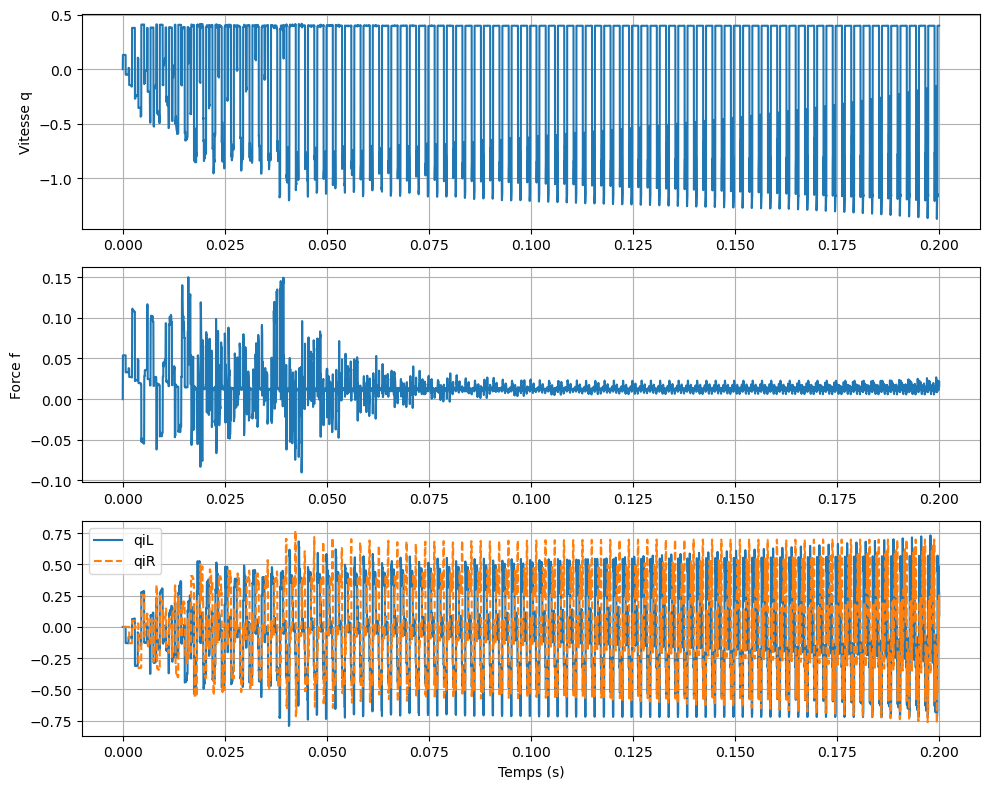

In [4]:
# Appel de la classe:

sim = SimulateurViolon(T_sec=0.2, Fb=0.3, vb=0.4)
resultats = sim.executer()
sim.plot(resultats)

# Partie Descripteur:


### Seront étudiés les descripteurs de régimes, puissance et justesse dans le cas d'une variation de la force de l'archet ainsi que de sa vitesse (Fb, vb)

Je reprends le code de Lalie pour pouvoir comparer les résultats obtenus entre violon et clarinette

Ici du coup, on fait varier la force de l'archet Fb

In [5]:
class LatinSquare : 

    def __init__(self, n_data, u, dims = 2):
        from scipy.stats import qmc
        self.n_data = n_data
        self.u = u
        self.dims = dims
        self.sampler = qmc.LatinHypercube(self.dims)

    def indices(self) : 
        """
        Renvoie une liste d'indices suivant une distribution en carré latin
        """
        return self.sampler.integers(self.u, n=self.n_data)

In [6]:
Fb = np.linspace(0,1,100)

carre_latin = LatinSquare(n_data = 50, u = len(Fb) - 1)
indexes = carre_latin.indices()

c = 20.05*np.sqrt(273.15 + 20)
L = 0.325

temps, f, q, q_iL, q_iR = sim.executer()

In [7]:
# ici on approxime la pression de l'onde résultante par la vitesse de la corde q (grosse approximation)

def descripteur_son(P) : 
    N = len(P)
    N_tiers = (2*N) // 3
    P_tiers = P[N_tiers:]
    return np.mean(P_tiers)

def classifieur_son(D_son, eps1) : 
    c = 0 # classe du son, 0 si régime statique ou 1 si régime oscillant
    if D_son > eps1 : 
        c = 1 
    return c

In [8]:
D_son = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i, "/50")
    sim = SimulateurViolon(T_sec=0.1, Fb=index[0])
    temps, f, q, q_iL, q_iR = sim.executer()
    D_son[i] = descripteur_son(q)

epoch : 0 /50
epoch : 1 /50
epoch : 2 /50
epoch : 3 /50
epoch : 4 /50
epoch : 5 /50
epoch : 6 /50
epoch : 7 /50
epoch : 8 /50
epoch : 9 /50
epoch : 10 /50
epoch : 11 /50
epoch : 12 /50
epoch : 13 /50
epoch : 14 /50
epoch : 15 /50
epoch : 16 /50
epoch : 17 /50
epoch : 18 /50
epoch : 19 /50
epoch : 20 /50
epoch : 21 /50
epoch : 22 /50
epoch : 23 /50
epoch : 24 /50
epoch : 25 /50
epoch : 26 /50
epoch : 27 /50
epoch : 28 /50
epoch : 29 /50
epoch : 30 /50
epoch : 31 /50
epoch : 32 /50
epoch : 33 /50
epoch : 34 /50
epoch : 35 /50
epoch : 36 /50
epoch : 37 /50
epoch : 38 /50
epoch : 39 /50
epoch : 40 /50
epoch : 41 /50
epoch : 42 /50
epoch : 43 /50
epoch : 44 /50
epoch : 45 /50
epoch : 46 /50
epoch : 47 /50
epoch : 48 /50
epoch : 49 /50


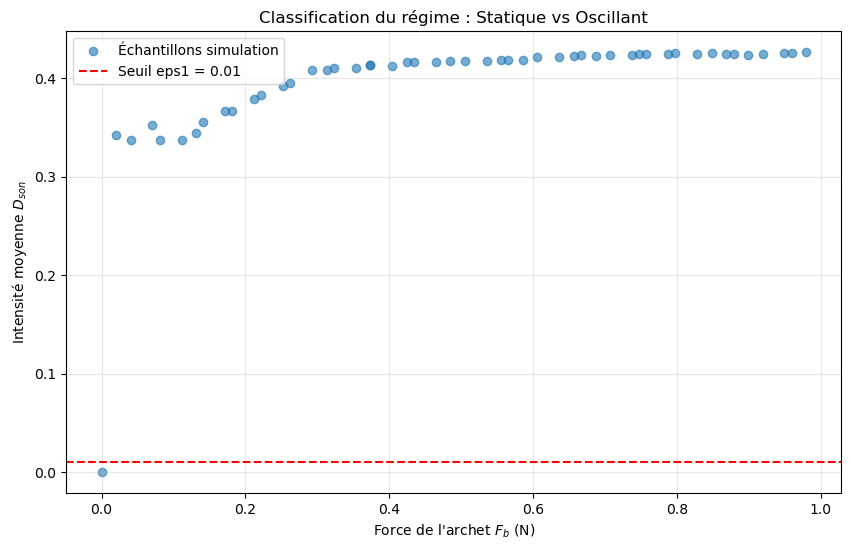

In [9]:
# visualisation:

eps1 = 0.01 # valeur seuil à ajuster/définir dans le cas de q
Fb_values = Fb[indexes[:, 0]]  # valeurs de Fb testées


plt.figure(figsize=(10, 6)) # (Fb , intensité)
plt.scatter(Fb_values, D_son, alpha=0.6, label="Échantillons simulation")

plt.axhline(y=eps1, color='r', linestyle='--', label=f"Seuil eps1 = {eps1}")

plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"Intensité moyenne $D_{son}$")
plt.title("Classification du régime : Statique vs Oscillant")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

### Le graphique ci-dessus permet de comparer les résultats obtenus entre les deux codes de Coline sur le violon.

### On fait à présent varier à la fois Fb et vb:

In [13]:
Fb_space = np.linspace(0.01, 1.0, 500)
vb_space = np.linspace(0.05, 0.5, 500)

carre_latin = LatinSquare(n_data=500, u=len(Fb_space) - 1, dims=2)
indexes = carre_latin.indices()


c = 20.05*np.sqrt(273.15 + 20)
L = 0.325

temps, f, q, q_iL, q_iR = sim.executer()

In [14]:
D_son = np.zeros(len(indexes))

for i, idx in enumerate(indexes): 
    val_Fb = Fb_space[idx[0]]
    val_vb = vb_space[idx[1]]
    
    print(f"Simulation {i+1}/500 : Fb={val_Fb:.2f}, vb={val_vb:.2f}")
    
    sim = SimulateurViolon(T_sec=0.15, Fb=val_Fb, vb=val_vb)
    temps, f, q, q_iL, q_iR = sim.executer()
    D_son[i] = descripteur_son(q)

Simulation 1/500 : Fb=0.96, vb=0.40
Simulation 2/500 : Fb=0.32, vb=0.15
Simulation 3/500 : Fb=0.13, vb=0.14
Simulation 4/500 : Fb=0.32, vb=0.06
Simulation 5/500 : Fb=0.47, vb=0.21
Simulation 6/500 : Fb=0.88, vb=0.32
Simulation 7/500 : Fb=0.71, vb=0.47
Simulation 8/500 : Fb=0.65, vb=0.48
Simulation 9/500 : Fb=0.20, vb=0.29
Simulation 10/500 : Fb=0.26, vb=0.12
Simulation 11/500 : Fb=0.52, vb=0.20
Simulation 12/500 : Fb=0.06, vb=0.26
Simulation 13/500 : Fb=0.43, vb=0.29
Simulation 14/500 : Fb=0.81, vb=0.14
Simulation 15/500 : Fb=1.00, vb=0.49
Simulation 16/500 : Fb=0.37, vb=0.11
Simulation 17/500 : Fb=0.89, vb=0.41
Simulation 18/500 : Fb=0.73, vb=0.44
Simulation 19/500 : Fb=0.36, vb=0.48
Simulation 20/500 : Fb=0.17, vb=0.34
Simulation 21/500 : Fb=0.79, vb=0.21
Simulation 22/500 : Fb=0.93, vb=0.24
Simulation 23/500 : Fb=0.34, vb=0.14
Simulation 24/500 : Fb=0.75, vb=0.08
Simulation 25/500 : Fb=0.01, vb=0.31
Simulation 26/500 : Fb=0.37, vb=0.15
Simulation 27/500 : Fb=0.53, vb=0.48
Simulation

C:\Users\julie\AppData\Local\Temp\ipykernel_1728\1393082672.py:3: RuntimeWarning: invalid value encountered in log10
  D_son_log = np.log10(D_son + 1e-12)


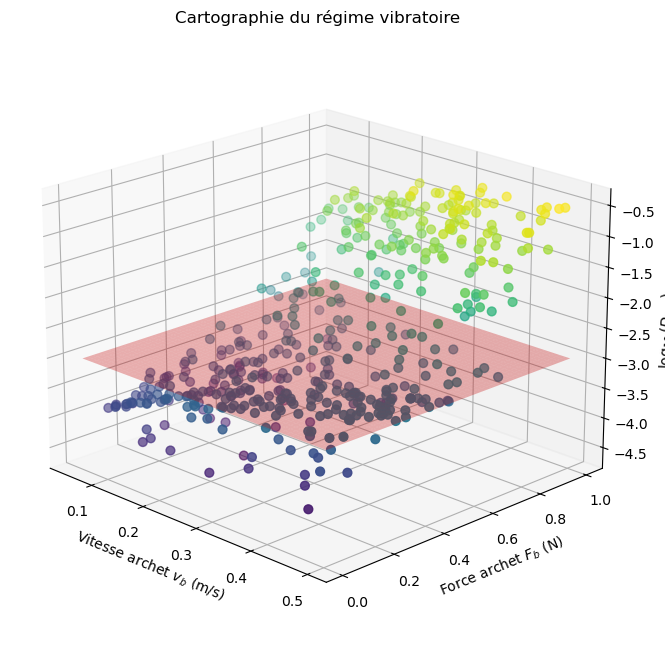

In [15]:
eps1 = 0.001 # Seuil d'intensité à adapter

D_son_log = np.log10(D_son + 1e-12)

axis_vb = np.linspace(0.05, 0.5, 500)
axis_Fb = np.linspace(0.01, 1.0, 500)
vi, fi = np.meshgrid(axis_vb, axis_Fb)
zi = np.full_like(vi, np.log10(eps1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], D_son_log, 
           c=D_son_log, cmap='viridis', s=40, label="Simulations")

ax.plot_surface(vi, fi, zi, alpha=0.3, color='red')

ax.set_xlabel(r"Vitesse archet $v_b$ (m/s)")
ax.set_ylabel(r"Force archet $F_b$ (N)")
ax.set_zlabel(r"$\log_{10}(D_{son})$")
ax.set_title("Cartographie du régime vibratoire")

ax.view_init(elev=20, azim=-45)
plt.show()

# 2eme descripteur: enveloppe de puissance

In [32]:
beta = 5/16
L_L = L*beta  
L_R = L*(1-beta)  
T_L = 2*L_L/c  
T_R = 2*L_R/c 
delta_t = min(T_L, T_R)/128

fs = 1/delta_t

Fb_space = np.linspace(0.01, 1.0, 500)
vb_space = np.linspace(0.05, 0.5, 500)

carre_latin = LatinSquare(n_data=500, u=len(Fb_space) - 1, dims=2)
indexes = carre_latin.indices()

0.0015170574188232422 0.01425933837890625 0.0019290447235107422


C:\Users\julie\AppData\Local\Temp\ipykernel_1728\2693090210.py:20: RuntimeWarning: invalid value encountered in sqrt
  power_meth2 = np.sqrt(np.convolve(q, kernel, mode='same'))


Text(0, 0.5, 'pwr')

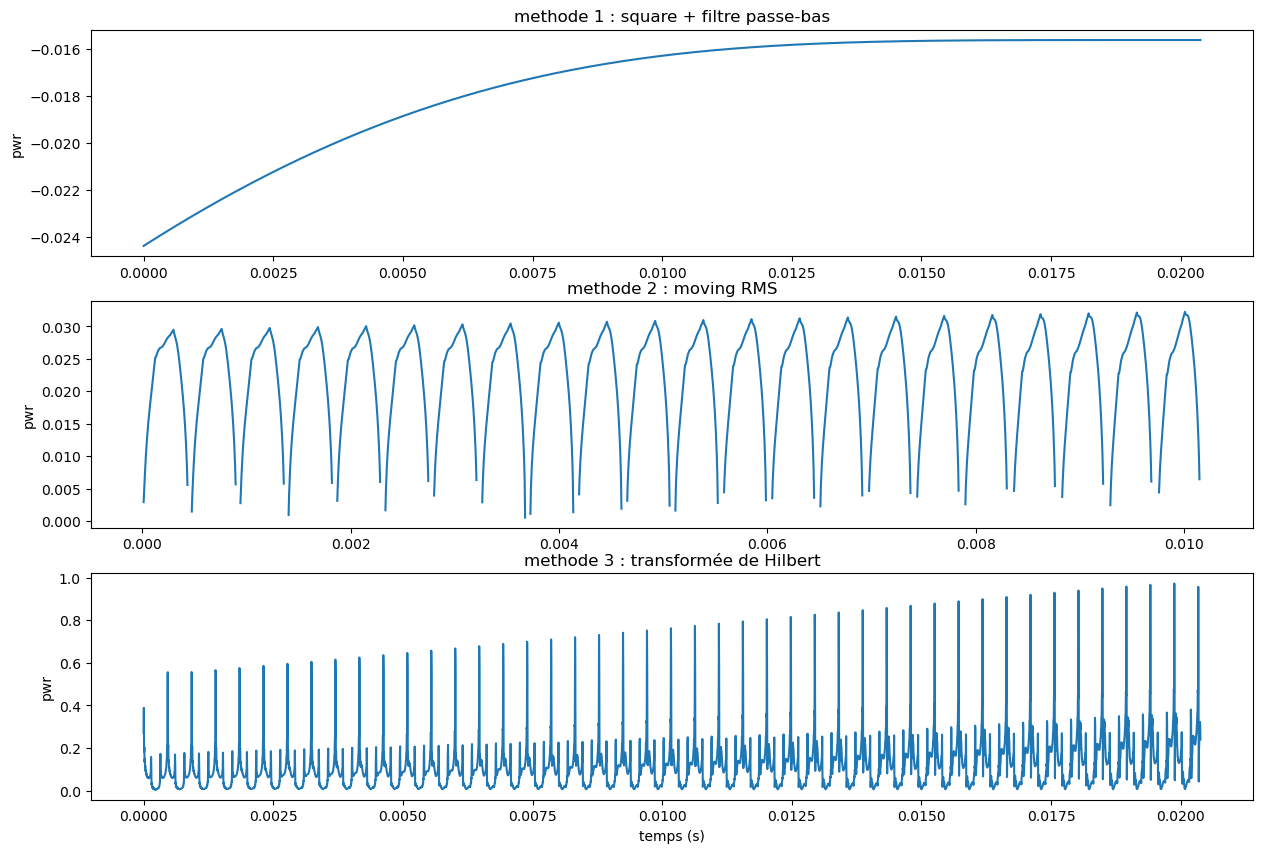

In [31]:
import time

# methode 1 : square + filtre passe-bas 
from scipy.signal import butter, filtfilt

start = time.time()

power = q**2
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (1 / (2*delta_t)), btype='low')
power_meth1 = filtfilt(b, a, power)
end = time.time()
temps1 = end - start

# methode 2 : moving RMS
window_ms = 50  # RMS window length
window_samples = int(fs * window_ms / 1000)
kernel = np.ones(window_samples) / window_samples
start = time.time()
power_meth2 = np.sqrt(np.convolve(q, kernel, mode='same'))
end = time.time()
temps2 = end - start

# methode 3 : transformée de Hilbert
from scipy.signal import hilbert

start = time.time()
analytic_signal = hilbert(q)
amplitude_envelope = np.abs(analytic_signal)
power_meth3 = amplitude_envelope**2
end = time.time()
temps3 = end - start

# plot
print(temps1, temps2, temps3)

plt.figure(figsize=(15,10))
plt.subplot(311)
plt.plot(np.arange(len(power_meth1))*delta_t, power_meth1)
plt.title("methode 1 : square + filtre passe-bas")
plt.ylabel("pwr")
plt.subplot(312)
plt.plot(np.arange(len(power_meth2))*delta_t, power_meth2)
plt.title("methode 2 : moving RMS")
plt.ylabel("pwr")
plt.subplot(313)
plt.plot(np.arange(len(power_meth3))*delta_t, power_meth3)
plt.title("methode 3 : transformée de Hilbert")
plt.xlabel("temps (s)")
plt.ylabel("pwr")

In [33]:
from scipy.signal import butter, filtfilt

fs = 1/delta_t
cutoff = 20  # enveloppe = ce qui varie lentement
b, a = butter(4, cutoff / (fs / 2), btype='low')

def descripteur_regime(q, cutoff = 20, fs = 1/delta_t):
    power = q**2
    pwr = filtfilt(b, a, power)
    D_regime = np.var(pwr)/np.mean(pwr)
    return D_regime

# Détermination de $\epsilon_2$

dur = 0.5
D_regime = np.zeros(len(indexes))

for i, index in enumerate(indexes): 
    print("epoch :", i + 1, "/500")
    sim = SimulateurViolon(T_sec=0.1, Fb=index[0],vb=index[1])
    temps, f, q, q_iL, q_iR = sim.executer()
    D_regime[i] = descripteur_regime(q)

epoch : 1 /500
epoch : 2 /500
epoch : 3 /500
epoch : 4 /500
epoch : 5 /500
epoch : 6 /500
epoch : 7 /500
epoch : 8 /500
epoch : 9 /500
epoch : 10 /500
epoch : 11 /500
epoch : 12 /500
epoch : 13 /500
epoch : 14 /500
epoch : 15 /500
epoch : 16 /500
epoch : 17 /500
epoch : 18 /500
epoch : 19 /500
epoch : 20 /500
epoch : 21 /500


C:\Users\julie\AppData\Local\Temp\ipykernel_1728\1232127515.py:10: RuntimeWarning: invalid value encountered in scalar divide
  D_regime = np.var(pwr)/np.mean(pwr)


epoch : 22 /500
epoch : 23 /500
epoch : 24 /500
epoch : 25 /500
epoch : 26 /500
epoch : 27 /500
epoch : 28 /500
epoch : 29 /500
epoch : 30 /500
epoch : 31 /500
epoch : 32 /500
epoch : 33 /500
epoch : 34 /500
epoch : 35 /500
epoch : 36 /500
epoch : 37 /500
epoch : 38 /500
epoch : 39 /500
epoch : 40 /500
epoch : 41 /500
epoch : 42 /500
epoch : 43 /500
epoch : 44 /500
epoch : 45 /500
epoch : 46 /500
epoch : 47 /500
epoch : 48 /500
epoch : 49 /500
epoch : 50 /500
epoch : 51 /500
epoch : 52 /500
epoch : 53 /500
epoch : 54 /500
epoch : 55 /500
epoch : 56 /500
epoch : 57 /500
epoch : 58 /500
epoch : 59 /500
epoch : 60 /500
epoch : 61 /500
epoch : 62 /500
epoch : 63 /500
epoch : 64 /500
epoch : 65 /500
epoch : 66 /500
epoch : 67 /500
epoch : 68 /500
epoch : 69 /500
epoch : 70 /500
epoch : 71 /500
epoch : 72 /500
epoch : 73 /500
epoch : 74 /500
epoch : 75 /500
epoch : 76 /500
epoch : 77 /500
epoch : 78 /500
epoch : 79 /500
epoch : 80 /500
epoch : 81 /500
epoch : 82 /500
epoch : 83 /500
epoch : 

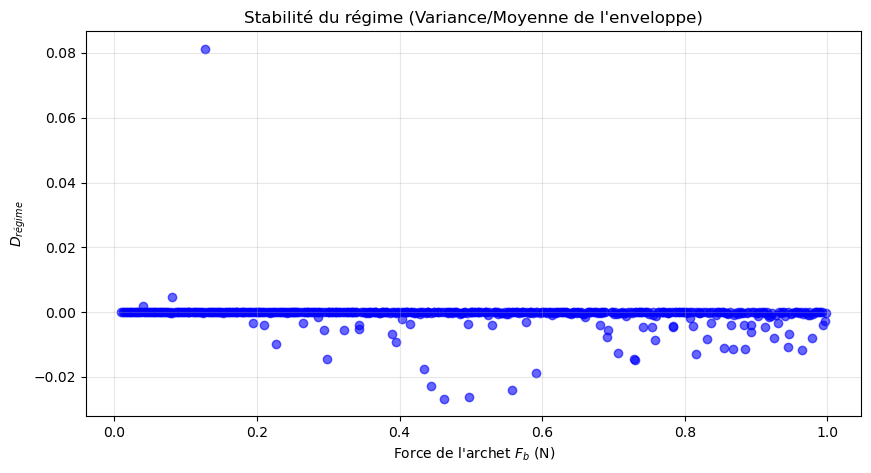

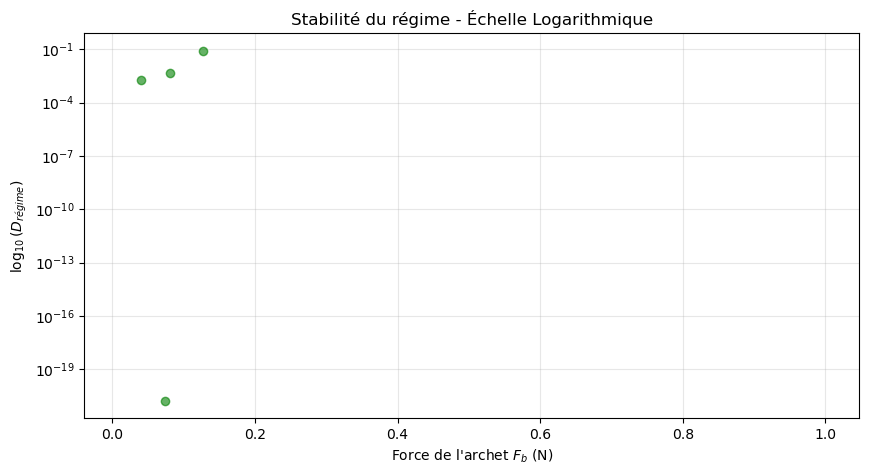

In [36]:
# Valeurs de Fb testées:

Fb_values = Fb_space[indexes[:, 0]]


plt.figure(figsize=(10, 5))
plt.scatter(Fb_values, D_regime, color='blue', alpha=0.6)
# plt.axhline(eps2, color="orange", linestyle="--", label="seuil de classification")
plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"$D_{régime}$")
plt.title("Stabilité du régime (Variance/Moyenne de l'enveloppe)")
plt.grid(True, alpha=0.3)
plt.show()

# Plot Semi-Log 
plt.figure(figsize=(10, 5))
plt.semilogy(Fb_values, D_regime, "go", alpha=0.6)
# plt.axhline(eps2, color="orange", linestyle="--", label="seuil de classification")
plt.xlabel(r"Force de l'archet $F_b$ (N)")
plt.ylabel(r"$\log_{10}(D_{régime})$")
plt.title("Stabilité du régime - Échelle Logarithmique")
plt.grid(True, which="both", alpha=0.3)
plt.show()

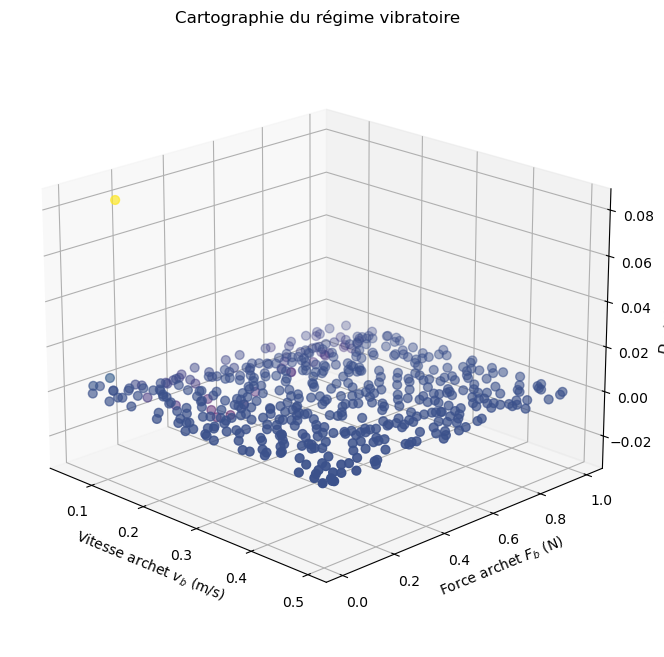

C:\Users\julie\AppData\Local\Temp\ipykernel_1728\935017102.py:39: RuntimeWarning: invalid value encountered in log10
  ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], np.log10(D_regime),


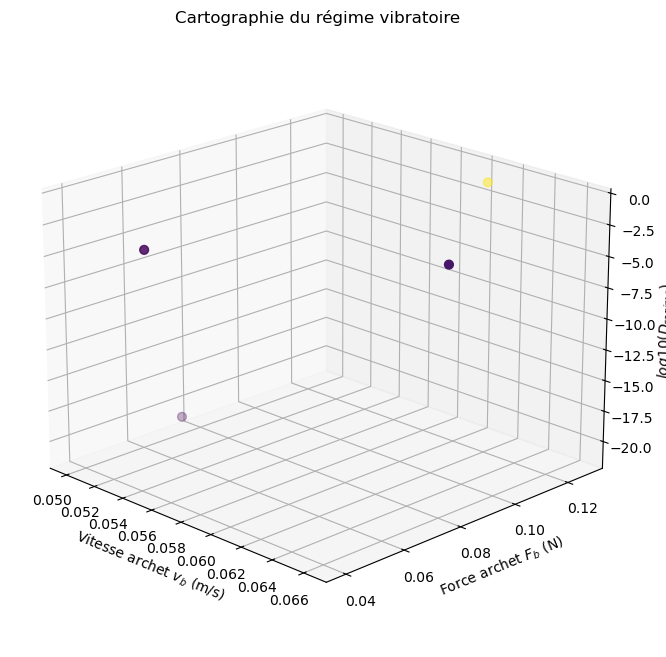

In [38]:
# Plot 3d (Fb,vb, descripteur)
# cartographie de D_regime


#eps1 = 0.001 # Seuil d'intensité à adapter

#D_son_log = np.log10(D_son + 1e-12)

axis_vb = np.linspace(0.05, 0.5, 500)
axis_Fb = np.linspace(0.01, 1.0, 500)

vi, fi = np.meshgrid(axis_vb, axis_Fb)
#zi = np.full_like(vi, np.log10(eps1))

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], D_regime, 
           c=D_regime, cmap='viridis', s=40, label="Simulations")

#ax.plot_surface(vi, fi, zi, alpha=0.3, color='red')

ax.set_xlabel(r"Vitesse archet $v_b$ (m/s)")
ax.set_ylabel(r"Force archet $F_b$ (N)")
ax.set_zlabel(r"$D_{regime}$")
ax.set_title("Cartographie du régime vibratoire")

ax.view_init(elev=20, azim=-45)
plt.show()

#############################################################################


fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')


ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], np.log10(D_regime), 
           c=D_regime, cmap='viridis', s=40, label="Simulations")

#ax.plot_surface(vi, fi, zi, alpha=0.3, color='red')

ax.set_xlabel(r"Vitesse archet $v_b$ (m/s)")
ax.set_ylabel(r"Force archet $F_b$ (N)")
ax.set_zlabel(r"$log10(D_{regime})$")
ax.set_title("Cartographie du régime vibratoire")

ax.view_init(elev=20, azim=-45)
plt.show()

### Deuxième manière de regarder le régime : spectral flatness

In [39]:
from scipy.stats import gmean

def descripteur_flatness(q, fs):
    """
    Calcule la Spectral Flatness (SFM) du signal.
    SFM proche de 0 -> Son tonal (Helmholtz)
    SFM proche de 1 -> Bruit
    """
    N = len(q)
    sig = q[2*N//3:] # Dernier tiers
    
    sig = sig * np.hamming(len(sig))
    
    spectre = np.abs(np.fft.rfft(sig))
    puissance = spectre**2
    
    eps = 1e-12
    m_arith = np.mean(puissance) + eps
    m_geo = gmean(puissance + eps)
    
    sfm = m_geo / m_arith
    
    return sfm

In [40]:
# Initialisation
D_flatness = np.zeros(len(indexes))

for i, idx in enumerate(indexes):
    val_Fb = Fb_space[idx[0]]
    val_vb = vb_space[idx[1]]
    
    # Simulation
    sim = SimulateurViolon(T_sec=0.2, Fb=val_Fb, vb=val_vb)
    temps, f, q, q_iL, q_iR = sim.executer()
    
    # Calcul de la flatness
    D_flatness[i] = descripteur_flatness(q, fs=44100)
    
    print(f"Échantillon {i+1}/500")

Échantillon 1/500
Échantillon 2/500
Échantillon 3/500
Échantillon 4/500
Échantillon 5/500
Échantillon 6/500
Échantillon 7/500
Échantillon 8/500
Échantillon 9/500
Échantillon 10/500
Échantillon 11/500
Échantillon 12/500
Échantillon 13/500
Échantillon 14/500
Échantillon 15/500
Échantillon 16/500
Échantillon 17/500
Échantillon 18/500
Échantillon 19/500
Échantillon 20/500
Échantillon 21/500
Échantillon 22/500
Échantillon 23/500
Échantillon 24/500
Échantillon 25/500
Échantillon 26/500
Échantillon 27/500
Échantillon 28/500
Échantillon 29/500
Échantillon 30/500
Échantillon 31/500
Échantillon 32/500
Échantillon 33/500
Échantillon 34/500
Échantillon 35/500
Échantillon 36/500
Échantillon 37/500
Échantillon 38/500
Échantillon 39/500
Échantillon 40/500
Échantillon 41/500
Échantillon 42/500
Échantillon 43/500
Échantillon 44/500
Échantillon 45/500
Échantillon 46/500
Échantillon 47/500
Échantillon 48/500
Échantillon 49/500
Échantillon 50/500
Échantillon 51/500
Échantillon 52/500
Échantillon 53/500
Éc

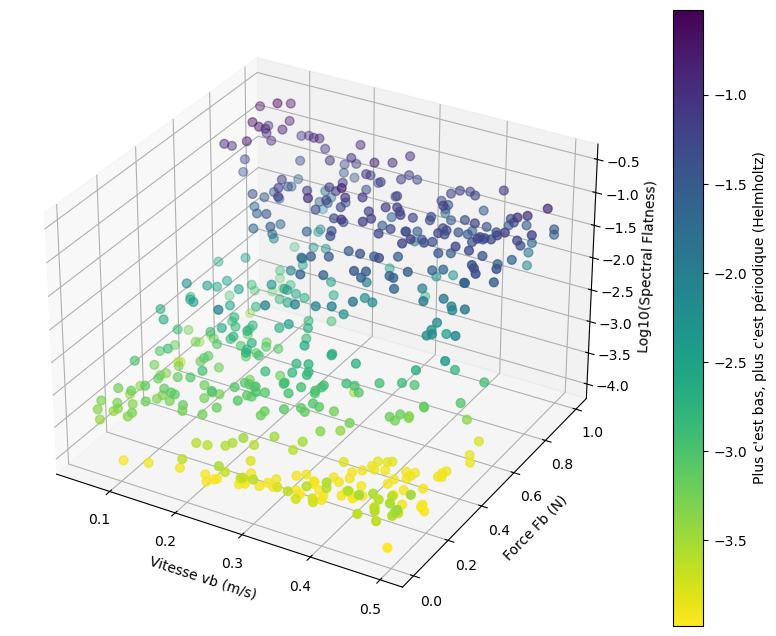

In [41]:
# On utilise souvent le log pour mieux voir les différences de Flatness
D_flatness_log = np.log10(D_flatness + 1e-12)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter
# On cherche les zones où D_flatness est BAS (proche de 0)
p = ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], D_flatness_log, 
               c=D_flatness_log, cmap='viridis_r', s=40)

ax.set_xlabel('Vitesse vb (m/s)')
ax.set_ylabel('Force Fb (N)')
ax.set_zlabel('Log10(Spectral Flatness)')
plt.colorbar(p, label="Plus c'est bas, plus c'est périodique (Helmholtz)")
plt.show()

In [42]:
# Vérification de la forme d'onde: est-ce que on a bien un régime de Helmholtz atteint pour des hautes valeurs de vb,Fb?

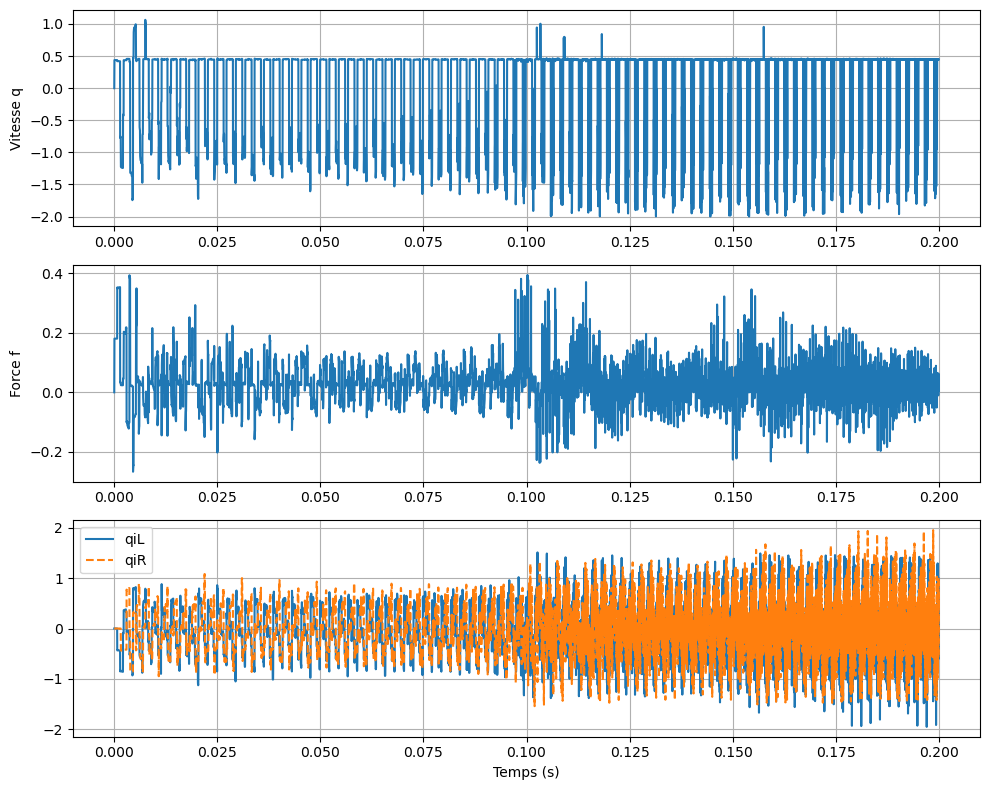

In [46]:
sim = SimulateurViolon(T_sec=0.2, Fb=0.8, vb=0.45)

resultats = sim.executer()
sim.plot(resultats)

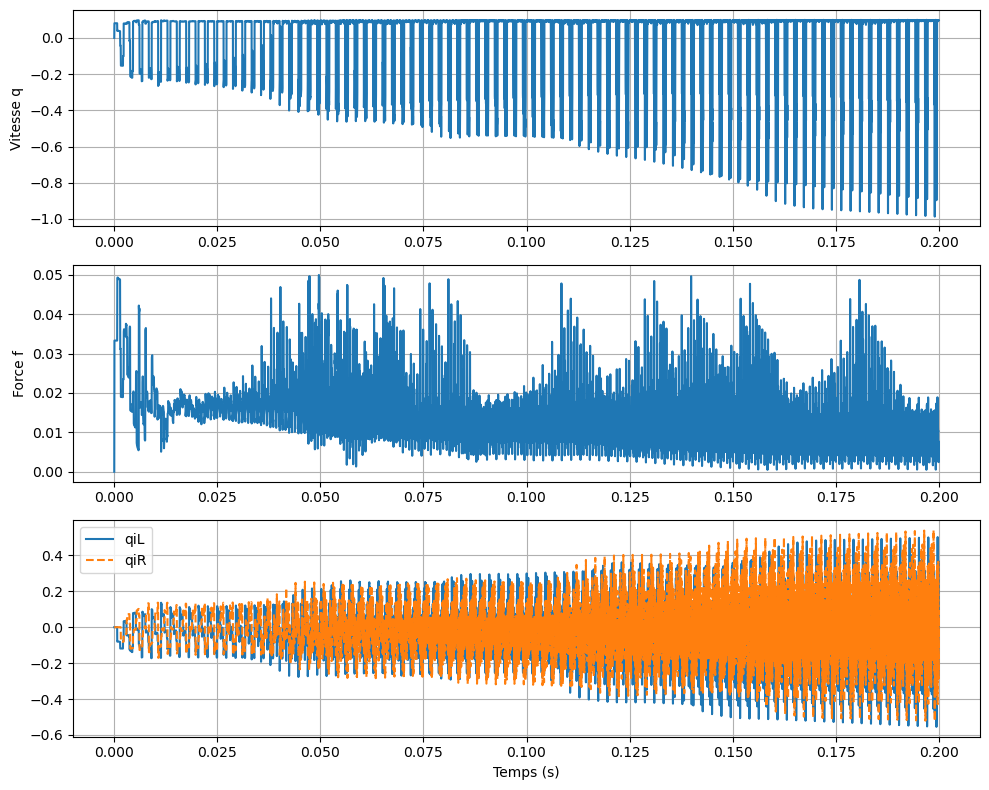

In [45]:
sim = SimulateurViolon(T_sec=0.2, Fb=0.1, vb=0.1)

resultats = sim.executer()
sim.plot(resultats)

# Justesse de la note

**Estimation de la fréquence fondamentale par la méthode du produit spectral** (source : TP TSM, Geoffroy Peeters)

Si nous notons $f_k = \frac{k}{N_{fft}}$ les fréquences discrètes de la DFT, le produit spectral est donné par:
\begin{equation}
    P(f_k) = \prod_{h=1}^{H} |X(h \cdot f_k)|
\end{equation}
Par défaut nous utiliserons $H$ = 4.

Détail des étapes de calcul :

Dans un premier temps, nous calculons la transformée de Fourier discrète (TFD) du signal $x(n)$ sur $N_{fft}$ points.
Nous commençons par multiplier $x(n)$ par une fenêtre de hamming de taille $L_n$ (ceci afin de diminuer la hauteur des lobes secondaires).

La longueur $L_n$ ainsi que le type de cette fenêtre détermine la **résolution fréquentielle**, i.e. le pouvoir de séparer en fréquence deux sinusoides adjacentes.

Le nombre de points de la la DFT, $N_{fft}$, détermine lui la **précision fréquentielle**., i.e. la distance en Hz entre $f_k$ et $f_{k+1}$.
Il faut impérativement utiliser une valeur de $N_{fft}$ supérieure à $L_n$. En pratique $N_{fft}$ est choisi comme une puissance de 2 de manière à pouvoir utiliser l'algorithme de FFT (Fast Fourier Transform). Ceci peut se calculer à l'aide de la fonction ```nextpow2```.

Calculer ensuite la transformée de Fourier Discrète $X(k)$.

In [48]:
class Classifier_justesse():
    def __init__(self, f_ref, eps3=5, delta_t=1e-5, L_sec=0.1, H=4, fmin=50, fmax=900):
        self.f_ref = f_ref
        self.eps3 = eps3 # cents
        self.fs = 1/delta_t
        self.L_sec = L_sec
        self.L_n = int(L_sec * self.fs)
        self.Nfft = 4 * self.nextpow2(self.L_n)
        self.H = H
        self.fmin = fmin
        self.fmax = fmax

    def nextpow2(self, i):
        n = 1
        while n < i: n *= 2
        return n
    
    def get_spectre(self, x):
        # On prend les L_n derniers points pour garantir la stabilité
        if len(x) < self.L_n:
            sig = np.pad(x, (0, self.L_n - len(x)))
        else:
            sig = x[-self.L_n:] # On prend la FIN du signal
            
        sig = sig * np.hamming(self.L_n)
        fftFreq_hz_v = np.fft.rfftfreq(self.Nfft, d=1/self.fs) # rfft est plus efficace
        fftAmpl_v = np.abs(np.fft.rfft(sig, self.Nfft))
        return fftFreq_hz_v, fftAmpl_v

    def get_pitch(self, P):
        fftFreq_hz_v, fftAmpl_v = self.get_spectre(P)
        # On limite la recherche à R pour le produit spectral
        R = int(self.Nfft/(2*self.H) + 1)
        spAmpl_v = np.ones(R)
        
        for h in range(self.H):
            # Compression spectrale
            X = fftAmpl_v[::h+1]
            longueur = min(len(spAmpl_v), len(X))
            spAmpl_v[:longueur] *= X[:longueur]
            
        # Masquage des fréquences hors limites
        idx_min = int(self.fmin * self.Nfft / self.fs)
        idx_max = int(self.fmax * self.Nfft / self.fs)
        
        i_max = np.argmax(spAmpl_v[idx_min:idx_max]) + idx_min
        f0_hz = fftFreq_hz_v[i_max]
        return f0_hz

    def descripteur_justesse(self, P):
        f_act = self.get_pitch(P)
        if f_act <= 0: return 999 # Erreur
        D_note = 1200 * np.log2(f_act / self.f_ref)
        return D_note
    
    def classifieur_justesse(self, P):
        D_note = self.descripteur_justesse(P)
        return 1 if np.abs(D_note) < self.eps3 else 0

In [50]:
f0_cible = 440
eps3 = 10

clf_j = Classifier_justesse(f_ref=f0_cible, eps3=eps3, delta_t=sim.delta_t)

D_note = np.zeros(len(indexes))
C_justesse = np.zeros(len(indexes))

for i, index_pair in enumerate(indexes):
    val_Fb = Fb_space[index_pair[0]]
    val_vb = vb_space[index_pair[1]]
    
    # on augmente T_sec pour avoir une note bien établie, sinon on est toujours dans le régime transitoire à coup sûr (0.3 pas suffisant ou tout juste remarque)
    
    sim = SimulateurViolon(T_sec=0.3, Fb=val_Fb,vb=val_vb)
    temps, f, q, q_iL, q_iR = sim.executer()
    
    D_note[i] = clf_j.descripteur_justesse(q)

    C_justesse[i] = clf_j.classifieur_justesse(q)
    
    print(f"Progression : {i+1}/500")

Progression : 1/50
Progression : 2/50
Progression : 3/50
Progression : 4/50
Progression : 5/50
Progression : 6/50
Progression : 7/50
Progression : 8/50
Progression : 9/50
Progression : 10/50
Progression : 11/50
Progression : 12/50
Progression : 13/50
Progression : 14/50
Progression : 15/50
Progression : 16/50
Progression : 17/50
Progression : 18/50
Progression : 19/50
Progression : 20/50
Progression : 21/50
Progression : 22/50
Progression : 23/50
Progression : 24/50
Progression : 25/50
Progression : 26/50
Progression : 27/50
Progression : 28/50
Progression : 29/50
Progression : 30/50
Progression : 31/50
Progression : 32/50
Progression : 33/50
Progression : 34/50
Progression : 35/50
Progression : 36/50
Progression : 37/50
Progression : 38/50
Progression : 39/50
Progression : 40/50
Progression : 41/50
Progression : 42/50
Progression : 43/50
Progression : 44/50
Progression : 45/50
Progression : 46/50
Progression : 47/50
Progression : 48/50
Progression : 49/50
Progression : 50/50
Progressi

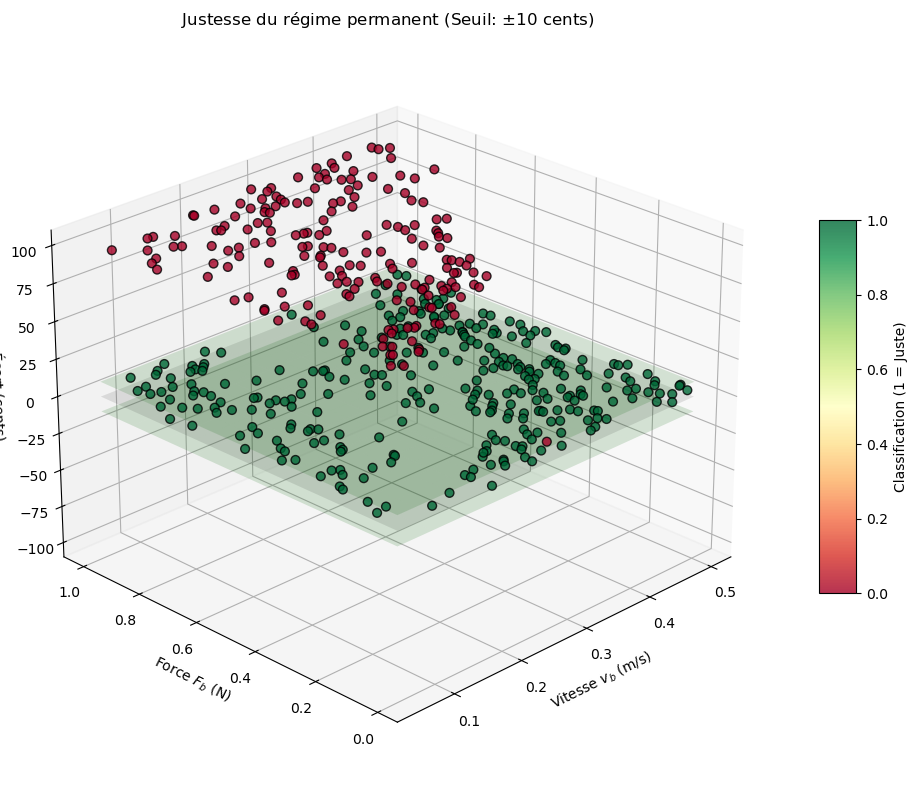

In [53]:
# indices du carré latin:
Fb_vals = Fb_space[indexes[:, 0]]
vb_vals = vb_space[indexes[:, 1]]

# On limite les valeurs de D_note pour le plot car certaines valeurs sont énormes
# Donc on clip à +/- 100 cents pour que le graphique reste lisible
D_note_clipped = np.clip(D_note, -100, 100)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(vb_vals, Fb_vals, D_note_clipped, 
                     c=C_justesse, cmap='RdYlGn', 
                     s=40, edgecolors='k', alpha=0.8,
                     label="Simulations")

v_surf, f_surf = np.meshgrid(np.linspace(vb_space.min(), vb_space.max(), 10),
                             np.linspace(Fb_space.min(), Fb_space.max(), 10))
z_plus = np.full_like(v_surf, eps3)
z_moins = np.full_like(v_surf, -eps3)

ax.plot_surface(v_surf, f_surf, z_plus, color='green', alpha=0.15)
ax.plot_surface(v_surf, f_surf, z_moins, color='green', alpha=0.15)
ax.plot_surface(v_surf, f_surf, np.zeros_like(v_surf), color='black', alpha=0.1) # Plan 0

ax.set_xlabel(r"Vitesse $v_b$ (m/s)")
ax.set_ylabel(r"Force $F_b$ (N)")
ax.set_zlabel("Écart (cents)")
ax.set_zlim(-110, 110) # On fixe les limites pour voir le tunnel
ax.set_title(f"Justesse du régime permanent (Seuil: $\pm${eps3} cents)")

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Classification (1 = Juste)')

ax.view_init(elev=25, azim=-135)

plt.tight_layout()
plt.show()

# Détection du régime transitoire 

et exploration de l'utilité de la durée du régime "pré-Helmholtz" en tant que descripteur

Basé sur les travaux de Victor Salvador Castrillo (2024) et adapté dans notre cas

In [77]:
class transients:
    def __init__(self,sig,string_frequency,sr=44100):

        self.sig = sig
        self.string_frequency = string_frequency
        self.sr = sr
        
        # Parameters for sliding window algorithms
        self.hop_size = 128
        self.win_len = 2048
        
        # Parameters for the onset detection (via scipy.signal.find_peaks)
        self.pp_prominence = 0.013
        self.pp_distance = 20
        self.pp_height = 1/2

        self.spf_th_wide = 24
        # Threshold for the maximum standard deviation of the sliding phases timestamps
        self.std_th = 0.6

        # Stockage des résultats
        self.abs_sig_diff = np.abs(np.diff(self.sig))
        self.onsets = None
        self.transient_ends = []
        self.durations = []

        # Données pour le plot
        self.peaks = None
        self.pp_height = None
        self.nb_peaks = None
        self.spf_array = None
        self.std_peaks_array = None


    def detect_onsets_from_peaks(self,peaks,sr=44100,lagtime_peak=0.1):
        """Détecte les débuts d'attaques (onsets) à partir des pics de la dérivée."""
        
        lagtime_peak_samples = int(lagtime_peak*sr)
        onset_samples = []
        onset_frames = np.array([])

        time_vec = np.arange(len(self.abs_sig_diff)) / self.sr # time vector of the analyzed signal
        seuil_d_erreur = 15 # duration (number of period) when we want to make sure there are peaks after the onset's detection 
        # Only a peak can be an onset
        for i in range(len(peaks)):
            # If the peaks are in the first lagtime_peak seconds, we can not know
            # if it is an onset
            if peaks[i] < lagtime_peak_samples:
                continue
        
            # Check if we have enough peaks remaining in the list
            if i + seuil_d_erreur >= len(peaks):
                break  # Sortir de la boucle si on dépasse la taille de peaks
            
            
            # Number of peaks detected lagtime_peak seconds before current peak
            arethey_peaks_before = len(np.where(
                np.logical_and(peaks >= peaks[i] - lagtime_peak_samples,
                           peaks < peaks[i]))[0])
            # If there are no peaks lagtime_peak seconds before current peak
            # --> ONSET DETECTED
            if not arethey_peaks_before:
                dt = time_vec[peaks[i+seuil_d_erreur]] - time_vec[peaks[i]]
                if dt <= (1.5 * seuil_d_erreur) / self.string_frequency:
                    onset_samples.append(peaks[i])
                    
                    if (time[peaks[i+seuil_d_erreur]] - time[peaks[i]]) <= (1.5*seuil_d_erreur)/self.string_frequency: # we look if between the detected onset and the tolerance (seuil_d_erreur), there are other peaks, making sure that we are after a bow stroke    
                        onset_frames = np.append(onset_frames, peaks[i])  #Thus, the duration between the tolerance and the following peaks must be inferior than 1.5 * seuil_d_erreur (because some strokes have more inconsistent frequencies before Helmholtz motion)
                    else:
                        None
        
        return np.array(onset_samples)

    def analyze(self, pp_height_factor=0.5):
        
        # -- Calculate first difference of the signal in absolute value
        N_diff = len(self.abs_sig_diff)

        # -- Detect peaks from abs_sig_diff, i.e., detect slipping phases
        # Peak-picking algorithm parameters (pp): see pp_parameters section
        # Minimum height of the peaks: Adaptative threshold varying with
        # abs_sig_diff envelope
        # --> Minimum height = pp_height = maximum peak of the windowed
        #                      abs_sig_diff signal times factor
        
        # Seuil adaptatif (pp_height)
        self.pp_height = np.zeros(N_diff)
        for i in range(N_diff - self.win_len):
            self.pp_height[int(self.win_len/2) + i] = np.max(self.abs_sig_diff[i:self.win_len+i]) * pp_height_factor
        
        # Adjust initial and final height of signal (if not, height=0)
        half_win = int(self.win_len/2)
        self.pp_height[:half_win] = self.pp_height[half_win]
        self.pp_height[-half_win:] = self.pp_height[-half_win-1]
        
        # Detect peaks
        self.peaks, _ = scipy.signal.find_peaks(
            self.abs_sig_diff, 
            height=self.pp_height, 
            prominence=0.015 * np.max(self.abs_sig_diff),
            distance=1
        )
        
        # -- Detect onsets from peaks (first peak after 0.1 seconds of no peaks)
        self.onsets = self.detect_onsets_from_peaks(self.peaks)
        
        # -- Calculate number of peaks from abs_sig_diff signal, i.e. :
        # nb_peaks = number of slips in the temporal window of length = win_len
        self.nb_peaks = np.zeros(N_diff)
        for i in range(N_diff - self.win_len):
            self.nb_peaks[half_win + i] = np.sum((self.peaks >= i) & (self.peaks <= (self.win_len + i)))
            
        # -- ONSETS LOOP
    
        # Transient number index (transients are saved with an index for every
        # signal, starting from 0)
        # Array to store Slipping Phase (pseudo)Frequency (spf) values in Hz
        # Array to store standard deviation of the peak distribution in the
        # windowed abs_sig_diff signal
        self.spf_array = np.zeros(N_diff)
        self.std_peaks_array = np.zeros(N_diff)
        self.transient_ends = []
        self.durations = []

        spf_th_low = self.string_frequency / 2**(1/self.spf_th_wide)
        spf_th_up = self.string_frequency * 2**(1/self.spf_th_wide)
        
        # For every onset detected (and then transient candidate):
        for onset_samp in self.onsets:

            # -- Calculate transient length
            # How? -> parsing signal from current onset to next onset and
            # analysing mean and standard deviation
    
            # If last onset, then next onset = end of signal
            # End of transient, set to -1 in case of no transient detected
            transient_end = -1
            # Recherche de la fin du transitoire entre cet onset et le suivant
            # On limite la boucle de recherche
            search_range = range(onset_samp, N_diff - self.win_len)

            # -- ANALYSIS OF THE FREQUENCY AND STD OF THE SLIPS TO DETECT HELMHOLTZ
            # Sliding window algorithm to analyse both spf_array and str_peaks
            # functions, both with thresholds to detect the beginning of the
            # Helmholtz motion and thus the end of the transient
            
            for j in search_range:
                window = self.nb_peaks[j : j + self.win_len]
                mean_peaks = np.mean(window)
                spf = self.sr * mean_peaks / self.win_len
                std_peaks = np.std(window)
                
                self.spf_array[j] = spf
                self.std_peaks_array[j] = std_peaks
                
                # - MAIN DETECTING CONDITION:
                # Helmholtz regime is reached if:
                #   - frequency = frequency(string) in some bandwidth threshold
                #                   (spf_th_wide)
                #   - std < std_th
                # THEN --> break loop and go to next detected onset
                
                if (spf_th_low < spf < spf_th_up) and (std_peaks < self.std_th):
                    transient_end = j
                    break
            
            if transient_end != -1:
                self.transient_ends.append(transient_end)
                self.durations.append((transient_end - onset_samp) / self.sr)



    def plot(self, title="Analyse des Transitoires"):
        """Affiche les 5 sous-graphiques d'analyse."""
        if self.onsets is None:
            print("Erreur: Lancer .analyze() avant le plot.")
            return

        time_sig = np.arange(len(self.sig)) / self.sr
        time_diff = np.arange(len(self.abs_sig_diff)) / self.sr
        
        fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 10))
        
        ax[0].plot(time_sig, self.sig, label='Signal')
        for ons in self.onsets:
            ax[0].axvline(ons/self.sr, color='r', linestyle='--', alpha=0.7)
        ax[0].set_ylabel("Amp")
        ax[0].set_title(title)
        
        ax[1].plot(time_diff, self.abs_sig_diff, label='Abs Diff')
        ax[1].scatter(self.peaks/self.sr, self.abs_sig_diff[self.peaks], color='purple', marker='*', s=10)
        ax[1].plot(time_diff, self.pp_height, color='yellow', label='Threshold')
        ax[1].set_ylabel("Diff")
        
        ax[2].plot(time_diff, self.nb_peaks, label='Nb Slips')
        ax[2].set_ylabel("Slips")
        
        ax[3].plot(time_diff, self.spf_array, label='SPF (Hz)')
        spf_th_low = self.string_frequency / 2**(1/self.spf_th_wide)
        spf_th_up = self.string_frequency * 2**(1/self.spf_th_wide)
        ax[3].axhline(spf_th_low, color='g', linestyle='--')
        ax[3].axhline(spf_th_up, color='g', linestyle='--')
        ax[3].set_ylabel("Hz")
        
        ax[4].plot(time_diff, self.std_peaks_array, label='STD')
        ax[4].axhline(self.std_th, color='g', linestyle='--')
        ax[4].set_ylabel("STD")
        ax[4].set_xlabel("Time (s)")

        for i in range(len(self.transient_ends)):
            ax[0].axvspan(self.onsets[i]/self.sr, self.transient_ends[i]/self.sr, color='g', alpha=0.3)

        for a in ax:
            a.legend(loc='upper right', fontsize='small')
            
        plt.tight_layout()
        plt.show()

In [78]:
#### Pour créer un descripteur basé sur la longueur des transitoires sur des sons de durées si faibles, il y a matière à discussion

#### Néanmoins, si les signaux générés font 1 ou plusieurs secondes, un régime transitoires de plus de 100 ms serait 100 % audible et dérangeant

#### On part donc du principe (dans un premier temps) qu'on crée un descripteur/threshold qui permet de classifier la qualité d'un son
#### selon la durée de son transitoire: > 100 ms = mauvaise qualité ; < 100 ms = bonne qualité

In [79]:
threshold = 0.1 # seconde
durees_transitoires = np.zeros(len(indexes))

for i, index_pair in enumerate(indexes):
    val_Fb = Fb_space[index_pair[0]]
    val_vb = vb_space[index_pair[1]]

    sim = SimulateurViolon(T_sec=0.4, Fb=val_Fb, vb=val_vb)
    temps, f, q, q_iL, q_iR = sim.executer()
    
    obj_transient = transients(q, string_frequency=440)
    obj_transient.analyze(pp_height_factor=0.5)

    if len(obj_transient.durations) > 0:
        durees_transitoires[i] = obj_transient.durations[0]
    else:
        durees_transitoires[i] = 0.4
    
    print(f"Progression : {i+1}/500")

Progression : 10/500
Progression : 20/500
Progression : 30/500
Progression : 40/500
Progression : 50/500
Progression : 60/500
Progression : 70/500
Progression : 80/500
Progression : 90/500
Progression : 100/500
Progression : 110/500
Progression : 120/500
Progression : 130/500
Progression : 140/500
Progression : 150/500
Progression : 160/500
Progression : 170/500
Progression : 180/500
Progression : 190/500
Progression : 200/500
Progression : 210/500
Progression : 220/500
Progression : 230/500
Progression : 240/500
Progression : 250/500
Progression : 260/500
Progression : 270/500
Progression : 280/500
Progression : 290/500
Progression : 300/500
Progression : 310/500
Progression : 320/500
Progression : 330/500
Progression : 340/500
Progression : 350/500
Progression : 360/500
Progression : 370/500
Progression : 380/500
Progression : 390/500
Progression : 400/500
Progression : 410/500
Progression : 420/500
Progression : 430/500
Progression : 440/500
Progression : 450/500
Progression : 460/5

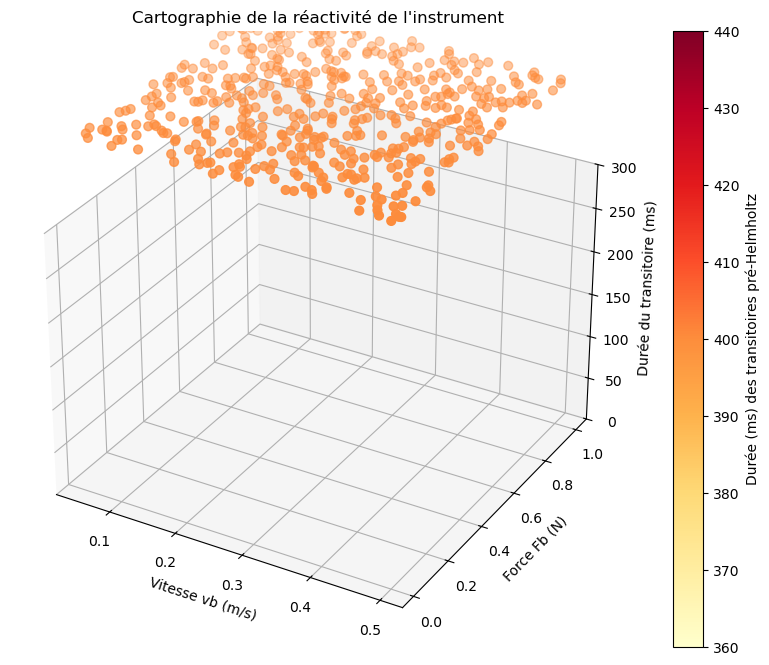

In [80]:
# Conversion en millisecondes:
durees_ms = durees_transitoires*1000

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(vb_space[indexes[:,1]], Fb_space[indexes[:,0]], durees_ms, 
               c=durees_ms, cmap='YlOrRd', s=40)

ax.set_xlabel('Vitesse vb (m/s)')
ax.set_ylabel('Force Fb (N)')
ax.set_zlabel('Durée du transitoire (ms)')
ax.set_title("Cartographie de la réactivité de l'instrument")

ax.set_zlim(0, 300) 

plt.colorbar(p, label="Durée (ms) des transitoires pré-Helmholtz")
plt.show()